#### Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers

#### Configuration

In [2]:
# サンプルデータのディレクトリのパス
data_dir = Path("./samples/")

# すべての画像のリストを取得
images = sorted(list(map(str, list(data_dir.glob('*.png')))))
labels = [img.split(os.path.sep)[-1].split('.png')[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [3]:
# Batch size 
batch_size = 16

# 画像の大きさ
img_width = 200
img_height = 50

# ダウンサンプリング
# クラス（カテゴリ）間でのサンプル数の偏りを解消する
downsample_factor = 4

# データセットのキャプチャの最大の長さ
max_length = max([len(label) for label in labels])  # データセットより"5"

#### Preprocessing

In [4]:
# 文字から整数へのマッピング
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# 整数を元の文字にマッピングする
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. 総データの数を取得
    size = len(images)
    # 2. Ndarray配列を作成し、必要に応じてシャッフルする
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. 学習データのサイズを取得
    train_samples = int(size * train_size)
    # 4. 学習データとバリデーションデータに分割
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

# 学習データとバリデーションデータに分割
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # 1. 画像の読み込み
    img = tf.io.read_file(img_path)
    # 2. デコードし、グレイスケールに変換
    img = tf.io.decode_png(img, channels=1)
    # 3. [0,1]のfloat32に変換
    img = tf.image.convert_image_dtype(img, tf.float32)
    # リサイズする
    img = tf.image.resize(img, size=[img_height, img_width])
    # 5. 時間軸を画像の幅に対応させたいので、画像を転置する
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. ラベルの文字を数字へマッピングする
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. モデルは2つの入力が必要なのでディクショナリで返す
    return {"image": img, "label": label}


#### Create Dataset objects

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE) # prefetch: 事前読み込み
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#### Visualize the data

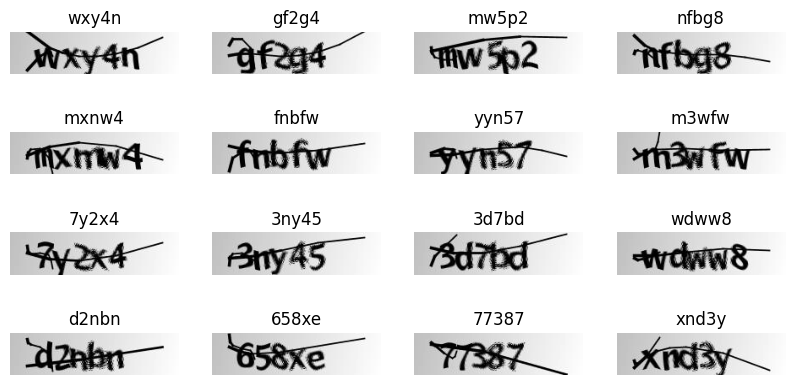

In [9]:
_, ax = plt.subplots(4,4, figsize=(10,5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:,:,0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

#### Model 

In [14]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        # self.add_loss() を使ってトレーニング時の損失を計算し、レイヤーに追加する
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # テスト時には計算された予測値を返す
        return y_pred
    
def build_model():
    # 入力層
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 第1Conv層
    x = layers.Conv2D(
        32,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1"
    )(input_img)
    x = layers.MaxPooling2D((2,2), name="pool1")(x)

    # 第2Conv層
    x = layers.Conv2D(
        64,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2,2), name="pool2")(x)

    # プールサイズとストライドの幅を２にして、2つのMaxPoolingを使用した。
    # 従って、ダウンサンプリングされた特徴量マップは4倍小さくなる。最終層のフィルター数は64。
    # RNNの部分に出力を渡す前に、それに応じて、Reshapeする。
    new_shape = (
        (img_width // 4), (img_height // 4)*64
    )
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # 出力層
    x = layers.Dense(
        len(char_to_num.get_vocabulary())+1, activation="softmax", name="dense2"
    )(x)

    # 各ステップでCTCロスを計算するためにCTCレイヤーを追加
    output = CTCLayer(name="ctc_loss")(labels, x)

    # モデルを定義
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # 識別機
    opt = keras.optimizers.legacy.Adam()
    # コンパイル
    model.compile(optimizer=opt)
    return model

# モデルを取得
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

#### Training

In [15]:
epochs = 100
early_stopping_patience = 10
# アーリーストッピングを追加
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# モデルを学習
histort = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
59/59 [==============================] - 13s 118ms/step - loss: 20.3607 - val_loss: 16.2928
Epoch 2/100
59/59 [==============================] - 5s 80ms/step - loss: 16.3769 - val_loss: 16.2678
Epoch 3/100
59/59 [==============================] - 5s 80ms/step - loss: 16.3630 - val_loss: 16.2608
Epoch 4/100
59/59 [==============================] - 5s 78ms/step - loss: 16.3533 - val_loss: 16.2568
Epoch 5/100
59/59 [==============================] - 5s 76ms/step - loss: 16.3474 - val_loss: 16.2538
Epoch 6/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3353 - val_loss: 16.2465
Epoch 7/100
59/59 [==============================] - 5s 77ms/step - loss: 16.3248 - val_loss: 16.2309
Epoch 8/100
59/59 [==============================] - 4s 75ms/step - loss: 16.3026 - val_loss: 16.1836
Epoch 9/100
59/59 [==============================] - 5s 80ms/step - loss: 16.2681 - val_loss: 16.1121
Epoch 10/100
59/59 [==============================] - 5s 77ms/step - loss: 16.14

#### Inference

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

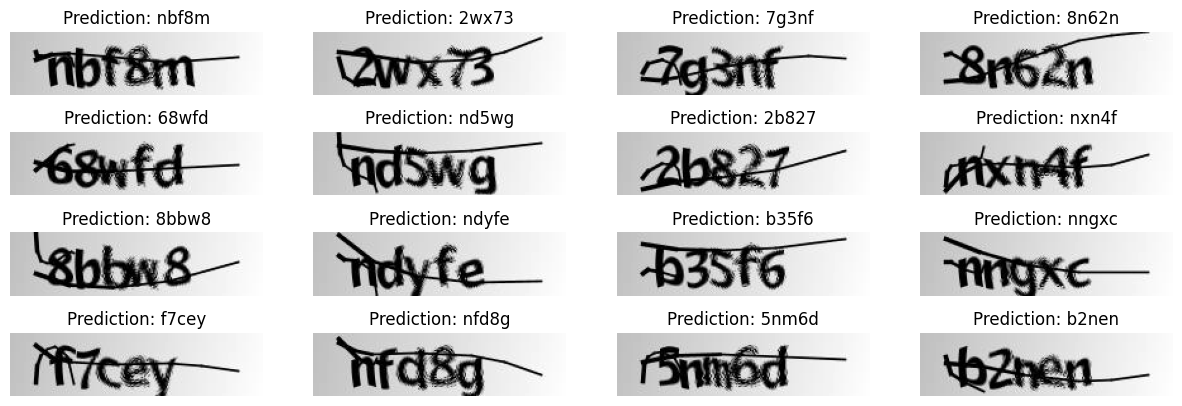

In [20]:
# 出力層までのレイヤーを抽出して予測モデルを得る
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# ネットワークの出力を解説する有効関数
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # greedy searchを使う。複雑なタスクにはbeam searchを使うこともできる
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:max_length]

    # 結果を反復処理し、テキストを返す
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)

    return output_text

# いくつかの検証サンプルで結果をチェック
for batch in validation_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        orig_texts.append(label)
    
    _, ax = plt.subplots(4,4,figsize=(15,5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()